In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import zipfile
import os

In [ ]:
# import keras Libraries
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.applications.vgg16 import VGG16
from keras.applications import ResNet50
from tensorflow.keras import optimizers
from IPython.display import Image
from keras.preprocessing.image import ImageDataGenerator
import cv2
import random

In [ ]:
train_path="/content/drive/MyDrive/spot mask/train_labels (2).csv"
train_labels=pd.read_csv(train_path)

In [ ]:
submission_path="/content/drive/MyDrive/spot mask/SampleSubmission (32).csv"
submission=pd.read_csv(submission_path)

In [ ]:
submission

,image,target
0,aadawlxbmapqrblgxyzarhjasgiobu.png,0
1,abpxvdfyhaaohzcrngcucmhffwizxs.jpg,0
2,aclkjfvackiieiznzfcwienplielrj.jpg,0
3,aelkivmayxgsdjosiibfgmkvfrjvjk.jpg,0
4,aelzzshpfxerelefnkatpczktuxjln.jpg,0
...,...,...
504,zpfhbgixcctxylnihhrepjgcmjksvf.jpg,0
505,zuignwckjykxefmpubjpjefvhghaoi.jpg,0
506,zuxvwdblfwjpibjexgfglpyreqslhs.jpg,0
507,zvyajojutzgqumdjfxxkpiuuxeefyy.jpg,0


<Axes: >

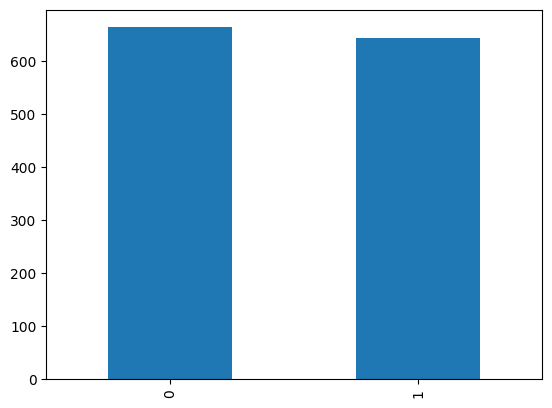

In [ ]:
train_labels['target'].value_counts().plot.bar()

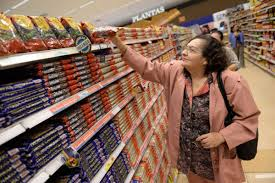

In [ ]:
Image("/content/drive/MyDrive/spot mask/images (2)/images/aaqrdyfhhsdwjiykofhsexfdamezlk.jpg")

In [ ]:
data=os.listdir("/content/drive/MyDrive/spot mask/images (2)/images/images/")
sample=random.choice(data)

In [ ]:
# we use imread method to load image from a specified file
img=cv2.imread("/content/drive/MyDrive/spot mask/images (2)/images/" + sample)

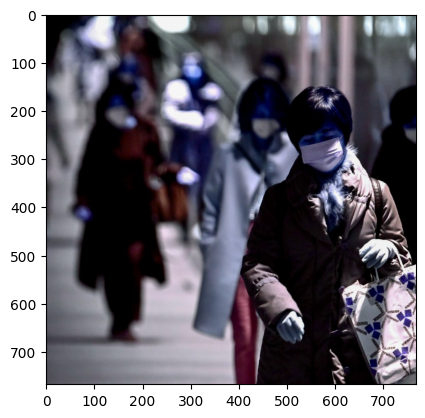

In [ ]:
plt.imshow(img, cmap="gray")

In [ ]:
train_labels

,image,target
0,tfymlmdkpzkqdjhdxyhnoeuqszxphw.jpg,0
1,rxgismgsvmaayzjarbfjaljhqmpbrt.jpg,1
2,uuzshfrhkgrkolhwdvliqauzulurnz.jpg,0
3,mjspxsagzusaznvnyxgamtrlqkqklp.jpg,0
4,rlbmuajgezfiddjzlyeoupxpqubkpt.jpg,1
...,...,...
1303,hxjwafskxmlfaotwaklzuwuccsbxfu.jpg,0
1304,oyodauphffgmzmvqlykcfvmyxartok.jpg,1
1305,uppvtemhkneqggtbfubeccqjvyefiw.png,1
1306,mzjjvzkzvqmyukzsegtoktaslejcdz.jpg,0


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [ ]:
# Split dataset into train and validation sets
train_df, val_df = train_test_split(train_labels, test_size=0.2, stratify=train_labels['target'], random_state=42)

In [ ]:
train_labels["target"] = train_labels["target"].replace({0: 'unmask', 1: 'mask'})

In [ ]:
# Defining how data is passed to the input layer
image_size = 224
input_shape = (image_size, image_size, 3)
batch_size = 16

In [ ]:
# Load the VGG16 model without the top (fully connected) layers
base_model = VGG16(weights="imagenet", include_top=False, input_shape=input_shape)

In [ ]:
# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = True

# Create a new model on top of the pre-trained base model
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))


In [ ]:
# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

# Data augmentation for training images
train_datagen = ImageDataGenerator(rotation_range=15,
                                   rescale=1./255,
                                   shear_range=0.1,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1)

In [ ]:
# Convert target values to string format
train_df['target'] = train_df['target'].astype(str)

In [ ]:
train_generator = train_datagen.flow_from_dataframe(dataframe=train_df,
                                                    directory="/content/drive/MyDrive/spot mask/images (2)/images/",
                                                    x_col="image",
                                                    y_col="target",
                                                    target_size=(image_size, image_size),
                                                    class_mode='categorical',
                                                    batch_size=batch_size)


Found 1046 validated image filenames belonging to 2 classes.


In [ ]:
val_df['target']=val_df['target'].astype(str)

In [ ]:
# Data augmentation for validation images
validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_dataframe(dataframe=val_df,
                                                              directory="/content/drive/MyDrive/spot mask/images (2)/images/",
                                                              x_col="image",
                                                              y_col="target",
                                                              target_size=(image_size, image_size),
                                                              class_mode='categorical',
                                                              batch_size=batch_size)


Found 262 validated image filenames belonging to 2 classes.


In [ ]:
# Make predictions on test images
submission_path = "/content/drive/MyDrive/spot mask/SampleSubmission (32).csv"
test_df = pd.read_csv(submission_path)

# Data augmentation for test images
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(dataframe=test_df,
                                                  directory="/content/drive/MyDrive/spot mask/images (2)/images/",
                                                  x_col='image',
                                                  y_col=None,
                                                  target_size=(image_size, image_size),
                                                  class_mode=None,
                                                  batch_size=batch_size,
                                                  shuffle=False)

# Predict probabilities for test images
test_predictions = model.predict(test_generator)

Found 509 validated image filenames.
32/32 [==============================] - 4s 118ms/step


In [ ]:
# Create submission DataFrame
submission = pd.DataFrame({'id': test_df['image'], 'label': test_predictions.argmax(axis=1)})

# Save submission DataFrame to a CSV file
submission.to_csv('spot_mask_submission.csv', index=False)

# Download the submission file
from google.colab import files
files.download('spot_mask_submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Set up callbacks
earlystop = EarlyStopping(patience=10)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=2, verbose=1, factor=0.5, min_lr=0.00001)
callbacks = [earlystop, learning_rate_reduction]

# Train the model
history = model.fit(train_generator,
                    steps_per_epoch=len(train_df) // batch_size,
                    epochs=10,
                    validation_data=validation_generator,
                    validation_steps=len(val_df) // batch_size,
                    callbacks=callbacks)

In [ ]:
pre_trained_model = VGG16(input_shape=input_shape, include_top=False, weights="imagenet")
for layer in pre_trained_model.layers[:15]:
    layer.trainable = False
for layer in pre_trained_model.layers[15:]:
    layer.trainable = True
last_layer = pre_trained_model.get_layer('block5_pool')
last_output = last_layer.output
x = GlobalMaxPooling2D()(last_output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(2, activation='softmax')(x)
model = Model(pre_trained_model.input, x)
model.compile(loss='binary_crossentropy',
optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
metrics=['accuracy'])
model.summary()

In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystop = EarlyStopping(patience=10)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',patience=2,verbose=1,factor=0.5,min_lr=0.00001)
callbacks = [earlystop, learning_rate_reduction]

In [ ]:
from sklearn.model_selection import train_test_split
train_df,validate_df=train_test_split(train_labels,test_size=0.2,random_state=42)
train_df = train_df.reset_index(drop='True')
validate_df = validate_df.reset_index(drop='True')

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from PIL import Image, ImageOps

In [ ]:
# Here we are formatting the training data
train_datagen = ImageDataGenerator(rotation_range=15,
                                 rescale=1./255,
                                 shear_range=0.1,
                                 zoom_range=0.2, # zoom range (1-0.2 to 1+0.2)
                                 horizontal_flip=True,
                                 width_shift_range=0.1,
                                 height_shift_range=0.1)
train_generator = train_datagen.flow_from_dataframe(dataframe=train_df,
                                                  directory="/content/drive/MyDrive/spot mask/images (2)/images/",
                                                  x_col="image",
                                                  y_col="target",
                                                  target_size=(image_size,image_size),
                                                  class_mode='categorical',
                                                  batch_size=16)
# Here we are formatting images on the validation data

In [ ]:
# Here we are formatting images on the validation data
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(validate_df,
                                                  directory="/content/drive/MyDrive/spot mask/images (2)/images/",
                                                  x_col="image",
                                                  y_col="target",
                                                  target_size=(image_size,image_size),
                                                  class_mode='categorical',
                                                  batch_size=16)

In [ ]:
# Create and compile the model
base_model = ResNet50(weights='imagenet', include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_df) // batch_size,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=len(validate_df) // batch_size
)

In [ ]:
# Make predictions on test images
submission_path = "/content/drive/MyDrive/spot mask/SampleSubmission (32).csv"
test_df = pd.read_csv(submission_path)


# Drop the 'target' column from test_df
test_df = test_df.drop(columns=['target'])

# Assuming 'image' column contains filenames relative to the directory
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory="/content/drive/MyDrive/spot mask/images (2)/images/",  # Set this to the directory containing the images
    x_col='image',
    y_col=None,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False
)

In [ ]:
# Predict probabilities for test images
test_predictions = model.predict(test_generator)

In [ ]:
# Create submission DataFrame
submission = pd.DataFrame({'id': test_df['image'], 'label': test_predictions.flatten()})

In [ ]:
# Save submission DataFrame to a CSV file
submission.to_csv('deepfake.csv', index=False)

# Download the submission file
from google.colab import files
files.download('deepfake.csv')